# Analytic continuation of a scalar Green's function with known spectrum

In this example, we will analytically continue a Matsubara Green's function for which we known the exact corresponding spectral function using OmegaMaxEnt_TRIQS. To do so, we will start from a spectrum $A(\omega)$ that is a sum of Gaussian functions and generate the corresponding Matsubara frequency Green's function using the spectral representation:

$$G(i\omega_n)=\int d\omega \frac{A(\omega)}{i\omega_n-\omega}\,,\qquad \text{(1)}$$

add noise to that function, and use OmegaMaxEnt_TRIQS to get back the real-frequency Green's function. First, we import the modules we need:

In [ ]:
import OmegaMaxEnt_TRIQS as OT
from math import ceil, exp, sqrt, pi
from pytriqs.dos import HilbertTransform, DOSFromFunction  #to compute G from A
from pytriqs.gf import *
import numpy as np
from pytriqs.plot.mpl_interface import oplot,plt  #to plot the result
import os
import shutil as su

Because the program produces files, it is better to create a working directory to group all the files:

In [2]:
output_dir = 'output_MaxEnt'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

Then, we define peaks using three lists: the peaks positions (*mw*), their standard deviations (*sd*), and  their weights (*wgt*). We also define an appropriate frequency range (*wmin, wmax*) outside of which the spectrum essentially vanishes:

In [3]:
mw = [-2, 0, 1]
sd = [1, 0.1, 0.4]
wgt = [1, 1, 1]
Wgts = sum(wgt)
Npks = len(mw)
wmin = -10
wmax = 10

Now, we define a function returning the value of the spectrum at *w*:

In [4]:
def spectr_val(w):
    v = 0
    for i in range(0,Npks):
        v = v+(wgt[i]/sd[i])*exp(-(w-mw[i])*(w-mw[i])/(2*sd[i]*sd[i]))
    return v/(Wgts*sqrt(2*pi))

which we have normalized. Now, we define an appropriate frequency step much smaller than the smallest peak width, and create a [DOSFromFunction][DFF] object:

[DFF]: https://triqs.github.io/triqs/master/reference/lattice_tools/dos.html?highlight=dosfromfunction

In [5]:
Dw = min(sd)/10
Npts = int((wmax-wmin)/Dw+1)
d = DOSFromFunction(spectr_val, wmin, wmax, Npts)

Then, we define the inverse temperature (*beta*) and a maximum Matsubara frequency much larger than the spectrum's cutoff frequency $W_{max,A}$, i.e. the maximum $|\omega|$ such that $A(\omega)>\epsilon $, where $\epsilon$ is very small:

In [6]:
beta = 50
wnmax = 30
n_freq = int(ceil(beta*wnmax/(2*pi)))

The fact that $wnmax\gg W_{max,A}$ is very useful to $\Omega MaxEnt$, because it allows to extract moments, which provide the mean frequency and the standard deviation of the spectrum. These are then used to define an appropriate default model and the frequency grid.

We can now compute the Green's function with the function [HilbertTransform][HT]:

[HT]: https://triqs.github.io/triqs/master/reference/lattice_tools/hilbert.html

In [ ]:
G = GfImFreq(indices=[0], beta=beta, n_points=n_freq)
Sigma0 = GfImFreq(indices=[0], beta=beta, n_points=n_freq) 
Sigma0.zero()
G << HilbertTransform(d)(Sigma=Sigma0)
G = G[0,0]

Now, let us define error vectors with constant relative error:

In [8]:
err = 1e-5 #relative error
err_abs_min = 1e-8 #minimal absolute error
errGr = err*np.abs(G.data.real)
# here we make sure the absolute error on the real part is not smaller than err_abs_min
errGr[errGr<err_abs_min] = err_abs_min
errGi = err*np.abs(G.data.imag)
ERRG = errGr+1j*errGi

We have set a minimal absolute error for the real part because it can vanish at some frequencies, or completely if the spectrum is symmetric. We have also defined the vector *ERRG* that has the same type and shape as *G.data* which will be passed to the function *compute_GfReFreq()*.

Then, we add normally distributed noise to _G_ using *errGr* and *errGi* as standard deviation vectors:

In [9]:
G.data.real = G.data.real+errGr*np.random.randn(2*n_freq)
G.data.imag = G.data.imag+errGi*np.random.randn(2*n_freq)

and run the function *compute_GfReFreq()* from the OmegaMaxEnt_TRIQS module:

In [10]:
GR = OT.compute_GfReFreq(G, ERR=ERRG, interactive_mode=False, displ_alpha_min_figs=False)

continuation done


Here we have set *interactive_mode=False* because the program's output figures cannot be displayed in separate windows when it is called from a notebook. We can however show those figures with the function *display_figures()* of the OmegaMaxEnt_TRIQS module. The parameter *displ_alpha_min_figs=False* prevents the code from producing the figures related to the last spectrum computed, i.e. at the lowest $\alpha$, which is not a valid result when the computation is successful, but is useful for the analysis of difficult cases. Note that you can also see the text output of $\Omega MaxEnt$ in the terminal where this notebook is running.

To display figures in a notebook use:

In [11]:
%matplotlib inline

and display the output figures with

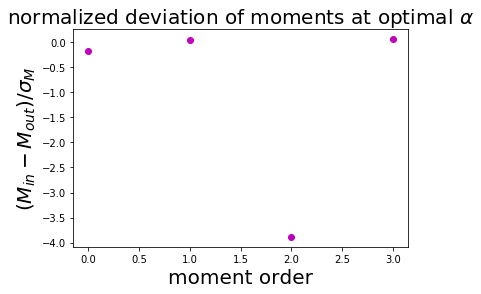

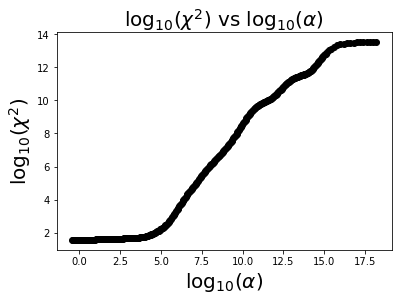

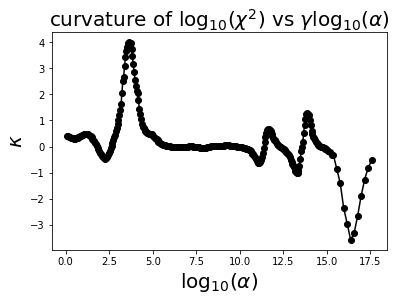

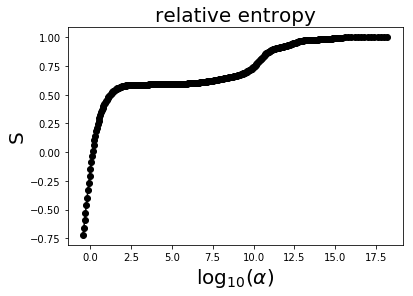

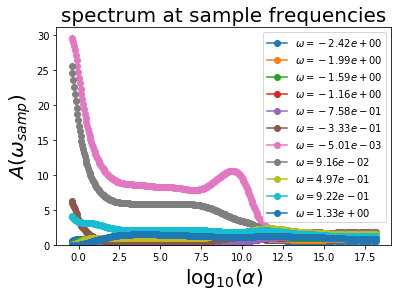

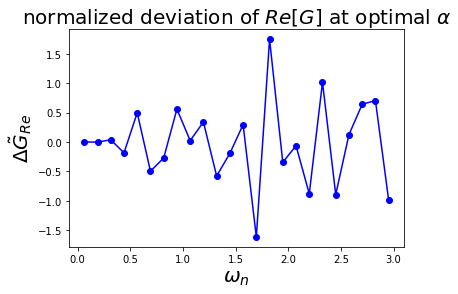

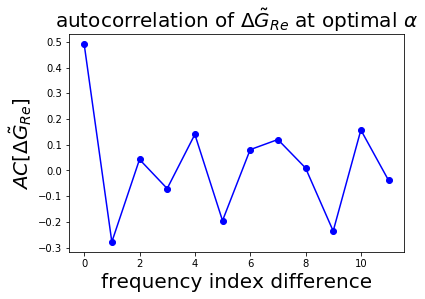

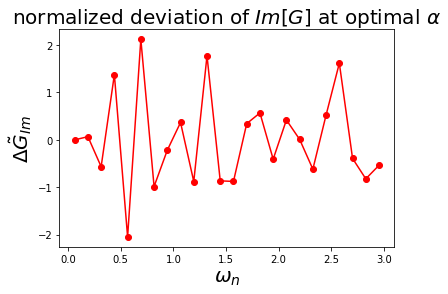

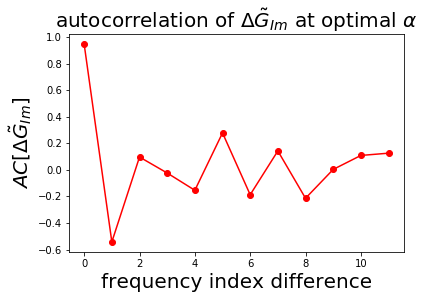

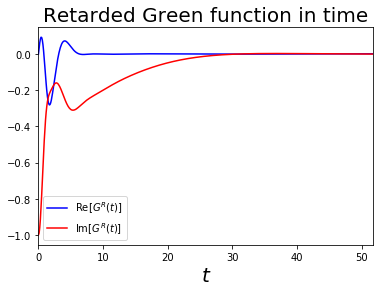

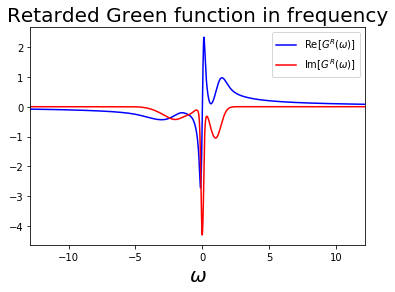

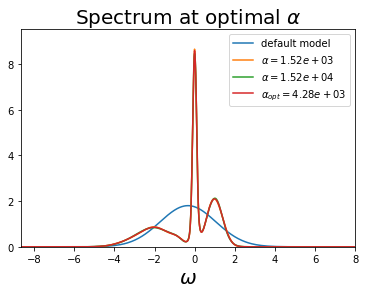

In [12]:
OT.display_figures()

The figure showing the resulting Green's function and spectrum should be the two last three ones, titled **Retarded Green function in time**, **Retarded Green function in frequency**, and **Spectrum at optimal $\alpha$**. 

The first figure is the errors on the moments, normalized by the standard deviations (parameters *err_norm* and *default_error_M*). The next figures are quantities plotted as functions of $\log\alpha$:

* $\log\chi^2$, which shows the three different regimes of MaxEnt: *default model* (flat region at high $\alpha$), *information fitting* (steep intermediate region), *noise fitting* (flat region at low $\alpha$),

* the curvature ($\kappa$) of $\log\chi^2$ vs. $\gamma\log\alpha$, which is used to determine the optimal $\alpha$ (the maximum of $\kappa$),

* the entropy *S* and

* the spectrum at sample frequencies, which is useful to determine how reliable different parts of the spectrum are, based on their stability with respect to $\log\alpha$.

Then we have the normalized deviations for the real and the imaginary part of $G$ and their autocorrelations. If the output Green's function, given by Eq.(1) using the optimal spectrum $A_{opt}(\omega)$, is a good fit to the input Green's function, the deviations curves must look like pure noise and their autocorrelations look like noisy Kronecker deltas. See the $\Omega MaxEnt$ [user guide][OME_user_guide] for more discussion on this subject.

[OME_user_guide]: https://www.physique.usherbrooke.ca/MaxEnt/index.php?title=User_Guide

For the comparision to the exact spectrum we switch to the interactive notebook mode using `%matplotlib notebook` instead of `%matplotlib inline`. This mode allows to resize figures and/or use the zoom tool to see more closely the difference between the exact result and the maxent result. Note that with `%matplotlib notebook`, the interactive mode of the figures must always be disabled before other interactive figures can be displayed.

Sometimes the command `%matplotlib notebook` does not work properly and the figures do not appear. If this happens can get a static figure by executing again the cell with `%matplotlib inline` above.

In [ ]:
%matplotlib notebook # should this not work in your notebook use %matpltlib inline

Now we define the spectrum on a grid and compare the imaginary part of *GR* with the exact spectrum:

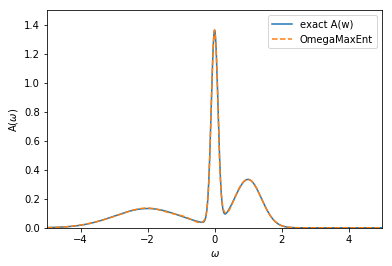

In [13]:
w = np.arange(-5,5,0.01)
Aw = np.array([spectr_val(wi) for wi in w])
plt.plot(w,Aw,label='exact A(w)')
oplot(GR, mode='S',ls='--',label='OmegaMaxEnt')
plt.ylabel(r'A($\omega$)')
plt.ylim(0,1.5)
plt.xlim(-5,5)
plt.legend()

In this example the error on the data was chosen to be small and the spectrum is not very complex, which is why the resulting spectrum is close to the exact one.

The next input will destroy the working directory.

In [14]:
os.chdir("..")
su.rmtree(output_dir)

## Exercise 1

Observe how the comparison between the exact and the reconstructed spectrum changes when using a different value
of the relative error, e.g. $10^{-2}$. What do you learn from this about analytic continuation of noisy data?

## Exercise 2


Start from two different spectra $A_1(\omega)$ and $A_2(\omega)$ defined by
$$
mw1=[-2, 0, 1]\\
sd1=[1, 0.2, 0.5]\\
wgt1=[1,1,1]\\
$$
and
$$
mw2=[-1, 1.5]\\
sd2=[0.3, 0.7]\\
wgt2=[1,1]
$$

and define a $2\times 2$ diagonal matrix Green's function at $\beta=50$. Then, compute a non-diagonal Green's function by applying a rotation of $\pi/8$, add normally distributed noise of constant magnitude of $10^{-4}$ and perform the analytic continuation of that Green's function matrix. Set parameter *inv_sym=True* in the call to *compute_GfReFreq()*. Finally, by using the definition of the spectral matrix:

$$\mathbf{A}(\omega)=\frac{i}{2\pi}\left[\mathbf{G}^R(\omega)-\left(\mathbf{G}^R(\omega)\right)^\dagger\right]\,,$$

compare the resulting three distinct spectra with the ones obtained from rotating the diagonal matrix with $A_1(\omega)$ and $A_2(\omega)$ on its diagonal.

For an example of how to construct a matrix Green's function see [here][local_Gf]. Also, you can use the member function *from_L_G_R()* of TRIQS Green's function objects to perform the rotation, the syntax being `G_rotated.from_L_G_R(R,G,R.transpose())`, where `G_rotated` and `G` are matrix-valued Green's functions and `R` is a rotation matrix of type *numpy.ndarray*.

[Here][solution] is the solution.

[solution]: https://github.com/TRIQS/omegamaxent_interface/blob/master/tutorials/Introduction%20to%20OmegaMaxEnt_TRIQS_solution.ipynb

[local_Gf]: https://triqs.github.io/triqs/master/tour/green.html